In [1]:
# This Python 3 environment comes with many helpful analytics libraries installed
# It is defined by the kaggle/python Docker image: https://github.com/kaggle/docker-python
# For example, here's several helpful packages to load

import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)

# Input data files are available in the read-only "../input/" directory
# For example, running this (by clicking run or pressing Shift+Enter) will list all files under the input directory

import os
for dirname, _, filenames in os.walk('/kaggle/input'):
    for filename in filenames:
        print(os.path.join(dirname, filename))

# You can write up to 5GB to the current directory (/kaggle/working/) that gets preserved as output when you create a version using "Save & Run All" 
# You can also write temporary files to /kaggle/temp/, but they won't be saved outside of the current session

/kaggle/input/question-pairs-dataset/questions.csv


In [2]:
import numpy as np
import pandas as pd
import tensorflow as tf
from tensorflow.keras.layers import Dense, Input, concatenate
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.models import Model
from tensorflow.keras.callbacks import EarlyStopping, ModelCheckpoint
from tensorflow.keras.callbacks import ModelCheckpoint
import tensorflow_hub as hub

from importlib import reload
import sys, re, gensim
from imp import reload
from nltk.corpus import stopwords
from gensim.models import KeyedVectors
import warnings

warnings.filterwarnings('ignore')

if sys.version[0] == '2':
    reload(sys)
    sys.setdefaultencoding("utf-8")

In [3]:
import pandas as pd
df = pd.read_csv('/kaggle/input/question-pairs-dataset/questions.csv')
df = df.drop(['id','qid1','qid2'],axis=1)
df.head()

,question1,question2,is_duplicate
0,What is the step by step guide to invest in sh...,What is the step by step guide to invest in sh...,0
1,What is the story of Kohinoor (Koh-i-Noor) Dia...,What would happen if the Indian government sto...,0
2,How can I increase the speed of my internet co...,How can Internet speed be increased by hacking...,0
3,Why am I mentally very lonely? How can I solve...,Find the remainder when [math]23^{24}[/math] i...,0
4,"Which one dissolve in water quikly sugar, salt...",Which fish would survive in salt water?,0


In [4]:
df = df[:100000]

In [5]:
contractions_dict = { 
"ain't": "am not / are not / is not / has not / have not",
"aren't": "are not / am not",
"can't": "cannot",
"can't've": "cannot have",
"'cause": "because",
"could've": "could have",
"couldn't": "could not",
"couldn't've": "could not have",
"didn't": "did not",
"doesn't": "does not",
"don't": "do not",
"hadn't": "had not",
"hadn't've": "had not have",
"hasn't": "has not",
"haven't": "have not",
"he'd": "he had / he would",
"he'd've": "he would have",
"he'll": "he shall / he will",
"he'll've": "he shall have / he will have",
"he's": "he has / he is",
"how'd": "how did",
"how'd'y": "how do you",
"how'll": "how will",
"how's": "how has / how is / how does",
"I'd": "I had / I would",
"I'd've": "I would have",
"I'll": "I shall / I will",
"I'll've": "I shall have / I will have",
"I'm": "I am",
"I've": "I have",
"isn't": "is not",
"it'd": "it had / it would",
"it'd've": "it would have",
"it'll": "it shall / it will",
"it'll've": "it shall have / it will have",
"it's": "it has / it is",
"let's": "let us",
"ma'am": "madam",
"mayn't": "may not",
"might've": "might have",
"mightn't": "might not",
"mightn't've": "might not have",
"must've": "must have",
"mustn't": "must not",
"mustn't've": "must not have",
"needn't": "need not",
"needn't've": "need not have",
"o'clock": "of the clock",
"oughtn't": "ought not",
"oughtn't've": "ought not have",
"shan't": "shall not",
"sha'n't": "shall not",
"shan't've": "shall not have",
"she'd": "she had / she would",
"she'd've": "she would have",
"she'll": "she shall / she will",
"she'll've": "she shall have / she will have",
"she's": "she has / she is",
"should've": "should have",
"shouldn't": "should not",
"shouldn't've": "should not have",
"so've": "so have",
"so's": "so as / so is",
"that'd": "that would / that had",
"that'd've": "that would have",
"that's": "that has / that is",
"there'd": "there had / there would",
"there'd've": "there would have",
"there's": "there has / there is",
"they'd": "they had / they would",
"they'd've": "they would have",
"they'll": "they shall / they will",
"they'll've": "they shall have / they will have",
"they're": "they are",
"they've": "they have",
"to've": "to have",
"wasn't": "was not",
"we'd": "we had / we would",
"we'd've": "we would have",
"we'll": "we will",
"we'll've": "we will have",
"we're": "we are",
"we've": "we have",
"weren't": "were not",
"what'll": "what shall / what will",
"what'll've": "what shall have / what will have",
"what're": "what are",
"what's": "what has / what is",
"what've": "what have",
"when's": "when has / when is",
"when've": "when have",
"where'd": "where did",
"where's": "where has / where is",
"where've": "where have",
"who'll": "who shall / who will",
"who'll've": "who shall have / who will have",
"who's": "who has / who is",
"who've": "who have",
"why's": "why has / why is",
"why've": "why have",
"will've": "will have",
"won't": "will not",
"won't've": "will not have",
"would've": "would have",
"wouldn't": "would not",
"wouldn't've": "would not have",
"y'all": "you all",
"y'all'd": "you all would",
"y'all'd've": "you all would have",
"y'all're": "you all are",
"y'all've": "you all have",
"you'd": "you had / you would",
"you'd've": "you would have",
"you'll": "you shall / you will",
"you'll've": "you shall have / you will have",
"you're": "you are",
"you've": "you have"
}

In [6]:
# contractions_re = re.compile('(%s)' % '|'.join(contractions_dict.keys()))
# def expand_contractions(s, contractions_dict=contractions_dict):
#     def replace(match):
#         return contractions_dict[match.group(0)]
#     return contractions_re.sub(replace, s)

# df["question1"] = df["question1"].apply(lambda x: expand_contractions(x)) 
# df["question2"] = df["question2"].apply(lambda x: expand_contractions(x)) 

In [7]:
stops = set(stopwords.words('english'))
def clean_text(text):

    # Clean the text
    text = re.sub(r"[^A-Za-z0-9^,!.\/'+-=]", " ", text)
    text = re.sub(r"(\d+)(k)", r"\g<1>000", text)
    text = re.sub(r":", " : ", text)
    text = re.sub(r",", " ", text)
    text = re.sub(r"\^", " ", text)
    text = re.sub(r"!", " ! ", text)
    text = re.sub(r"\/", " ", text)
    text = re.sub(r"\^\+\-\=\^\''", " ^ ", text)
    text = re.sub(r" e g ", " eg ", text)
    text = re.sub(r" b g ", " bg ", text)
    text = re.sub(r" u s ", " american ", text)
    text = re.sub(r"\0s", "0", text)
    text = re.sub(r" 9 11 ", "911", text)
    text = re.sub(r"e - mail", "email", text)
    text = re.sub(r"j k", "jk", text)
    text = re.sub(r"\s{2,}", " ", text)
    text = re.sub('\d', " ", text)
    text = text.split()
    text = [i.lower() for i in text if i not in stops]
    
    return text

In [8]:
# df["question1"] = df["question1"].apply(lambda x: clean_text(x)) 
# df["question2"] = df["question2"].apply(lambda x: clean_text(x)) 

In [9]:
import numpy as np
import pandas as pd
import tensorflow as tf
from tensorflow.keras.layers import Dense, Input, Concatenate
from tensorflow.keras.layers import  Bidirectional, LSTM
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.models import Model
from tensorflow.keras.callbacks import ModelCheckpoint
import tensorflow_hub as hub
from keras.callbacks import EarlyStopping

In [10]:
!wget --quiet https://raw.githubusercontent.com/tensorflow/models/master/official/nlp/bert/tokenization.py

In [11]:
import tokenization

In [12]:
def bert_encode(texts, tokenizer, max_len=512):
    all_tokens = []
    all_masks = []
    all_segments = []
    
    for text in texts:
        text = tokenizer.tokenize(text)
            
        text = text[:max_len-2]
        input_sequence = ["[CLS]"] + text + ["[SEP]"]
        pad_len = max_len - len(input_sequence)
        
        tokens = tokenizer.convert_tokens_to_ids(input_sequence)
        tokens += [0] * pad_len
        pad_masks = [1] * len(input_sequence) + [0] * pad_len
        segment_ids = [0] * max_len
        
        all_tokens.append(tokens)
        all_masks.append(pad_masks)
        all_segments.append(segment_ids)
    
    return np.array(all_tokens), np.array(all_masks), np.array(all_segments)

In [13]:
%%time
module_url = "https://tfhub.dev/tensorflow/bert_en_uncased_L-24_H-1024_A-16/1"
bert_layer = hub.KerasLayer(module_url, trainable=True)

CPU times: user 26.2 s, sys: 5.41 s, total: 31.6 s
Wall time: 39.6 s


In [14]:
vocab_file = bert_layer.resolved_object.vocab_file.asset_path.numpy()
do_lower_case = bert_layer.resolved_object.do_lower_case.numpy()
tokenizer = tokenization.FullTokenizer(vocab_file, do_lower_case)

In [15]:
df["question1"] = df["question1"].astype("str")
df["question2"] = df["question2"].astype("str")

In [16]:
from sklearn.model_selection import train_test_split

train, test, y_train, y_test = train_test_split(df[["question1", "question2"]], df["is_duplicate"], test_size = 0.75)

In [17]:
train_question1 = bert_encode([" ".join(i) for i in train["question1"]], tokenizer, max_len=160)
train_question2 = bert_encode([" ".join(i) for i in train["question2"]], tokenizer, max_len=160)

test_question1 = bert_encode([" ".join(i) for i in test["question1"]], tokenizer, max_len=160)
test_question2 = bert_encode([" ".join(i) for i in test["question2"]], tokenizer, max_len=160)

In [18]:
def build_model(bert_layer, max_len=512):
    input_word_ids1 = Input(shape=(max_len,), dtype=tf.int32, name="input_word_ids1")
    input_mask1 = Input(shape=(max_len,), dtype=tf.int32, name="input_mask1")
    segment_ids1 = Input(shape=(max_len,), dtype=tf.int32, name="segment_ids1")

    _, sequence_output1 = bert_layer([input_word_ids1, input_mask1, segment_ids1])
    clf_output1 = sequence_output1[:, 0, :]
    print(clf_output1.shape, sequence_output1.shape)
    
    input_word_ids2 = Input(shape=(max_len,), dtype=tf.int32, name="input_word_ids2")
    input_mask2 = Input(shape=(max_len,), dtype=tf.int32, name="input_mask2")
    segment_ids2 = Input(shape=(max_len,), dtype=tf.int32, name="segment_ids2")

    _, sequence_output2 = bert_layer([input_word_ids2, input_mask2, segment_ids2])
    clf_output2 = sequence_output2[:, 0, :]
#     out2 = Dense(64, activation='relu')(clf_output2)
    
    concat = Concatenate()([clf_output1, clf_output2])
    print(concat.shape)
#     lstm = Bidirectional(LSTM(10, return_sequences=True))(concat)
    
    out = Dense(64, activation='relu')(concat)
    out = Dense(1, activation='sigmoid')(out)
    
    model = Model(inputs=[input_word_ids1, input_mask1, segment_ids1,
                         input_word_ids2, input_mask2, segment_ids2], outputs=out)
    model.compile(Adam(lr=2e-6), loss='binary_crossentropy', metrics=['accuracy'])
    
    return model

In [19]:
model = build_model(bert_layer, max_len=160)
model.summary()

(None, 1024) (None, None, 1024)
(None, 2048)
Model: "model"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_word_ids1 (InputLayer)    [(None, 160)]        0                                            
__________________________________________________________________________________________________
input_mask1 (InputLayer)        [(None, 160)]        0                                            
__________________________________________________________________________________________________
segment_ids1 (InputLayer)       [(None, 160)]        0                                            
__________________________________________________________________________________________________
input_word_ids2 (InputLayer)    [(None, 160)]        0                                            
_________________________________________________

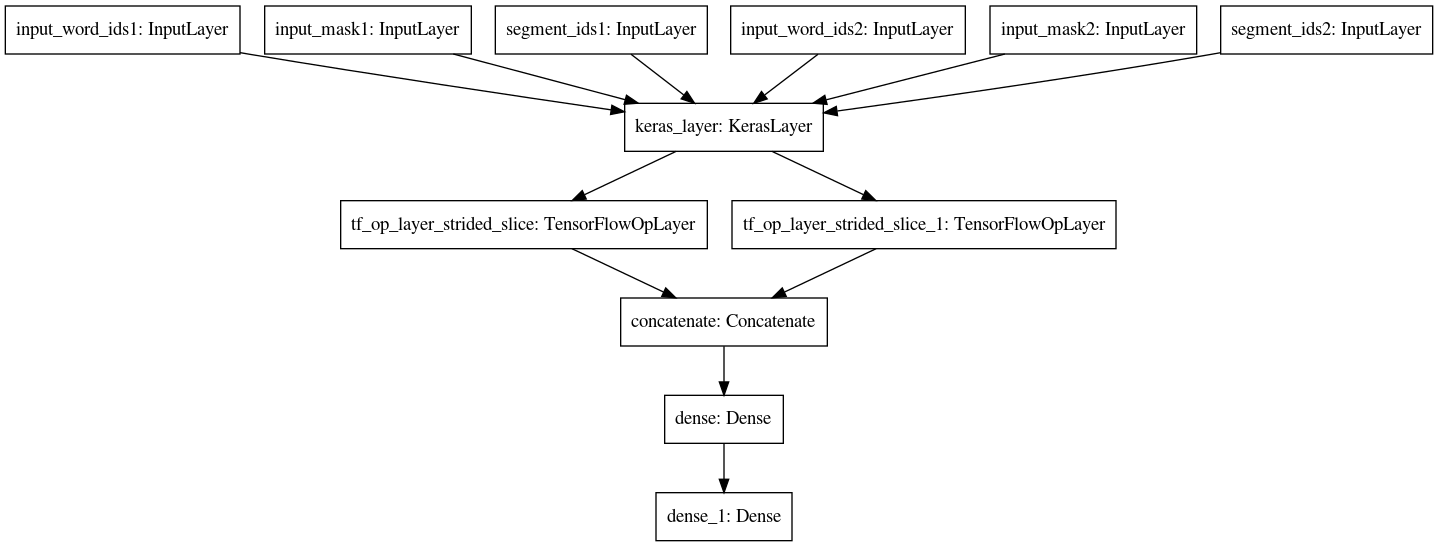

In [20]:
tf.keras.utils.plot_model(model, "my_first_model.png")

In [ ]:
early = EarlyStopping(monitor='val_loss',mode='auto', baseline=None, restore_best_weights=False)
train_history = model.fit(
    [train_question1, train_question2], y_train,
    validation_split=0.2,
    epochs=100,
    batch_size=16,
    callbacks=[early]
)

model.save('model.h5')

Epoch 1/100


In [ ]:
from sklearn.metrics import accuracy_score
predictions = model.predict([test_question1, test_question2])

for i in [0.5, 0.6, 0.4]:
    arr = [1 if j>i else 0 for j in predictions]
    print(accruacy_score(arr, y_test))

In [ ]:
sequence_0 = ["Reports that the NSA eavesdropped on world leaders have \"severely shaken\" relations between Europe and the U.S., German Chancellor Angela Merkel said.",
"Sehwag is played for india as per the BCCI",
"Quora is not user friendly so i prefer google because answers are available over there.",
"He said the foodservice pie business doesn't fit the company 's long-term growth strategy."
]
sequence_1 = ["Germany and France are to seek talks with the US to settle a row over spying, as espionage claims continue to overshadow an EU summit in Brussels.",
"Today I had a dream about spending a lot.",
"Why do people ask Quora questions which can be answered easily by Google?",
" The foodservice pie business does not fit our long-term growth strategy."
]

In [ ]:
input_data = [i+["SEP"]+j for i,j in zip(sequence_0, sequence_1)]

input_data = bert_encode(input_data, tokenizer)
model.predict(input_data)